/var/folders/hk/35r4d3px72v99cr1lfr8nw000000gn/T/ipykernel_82720/2001521411.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


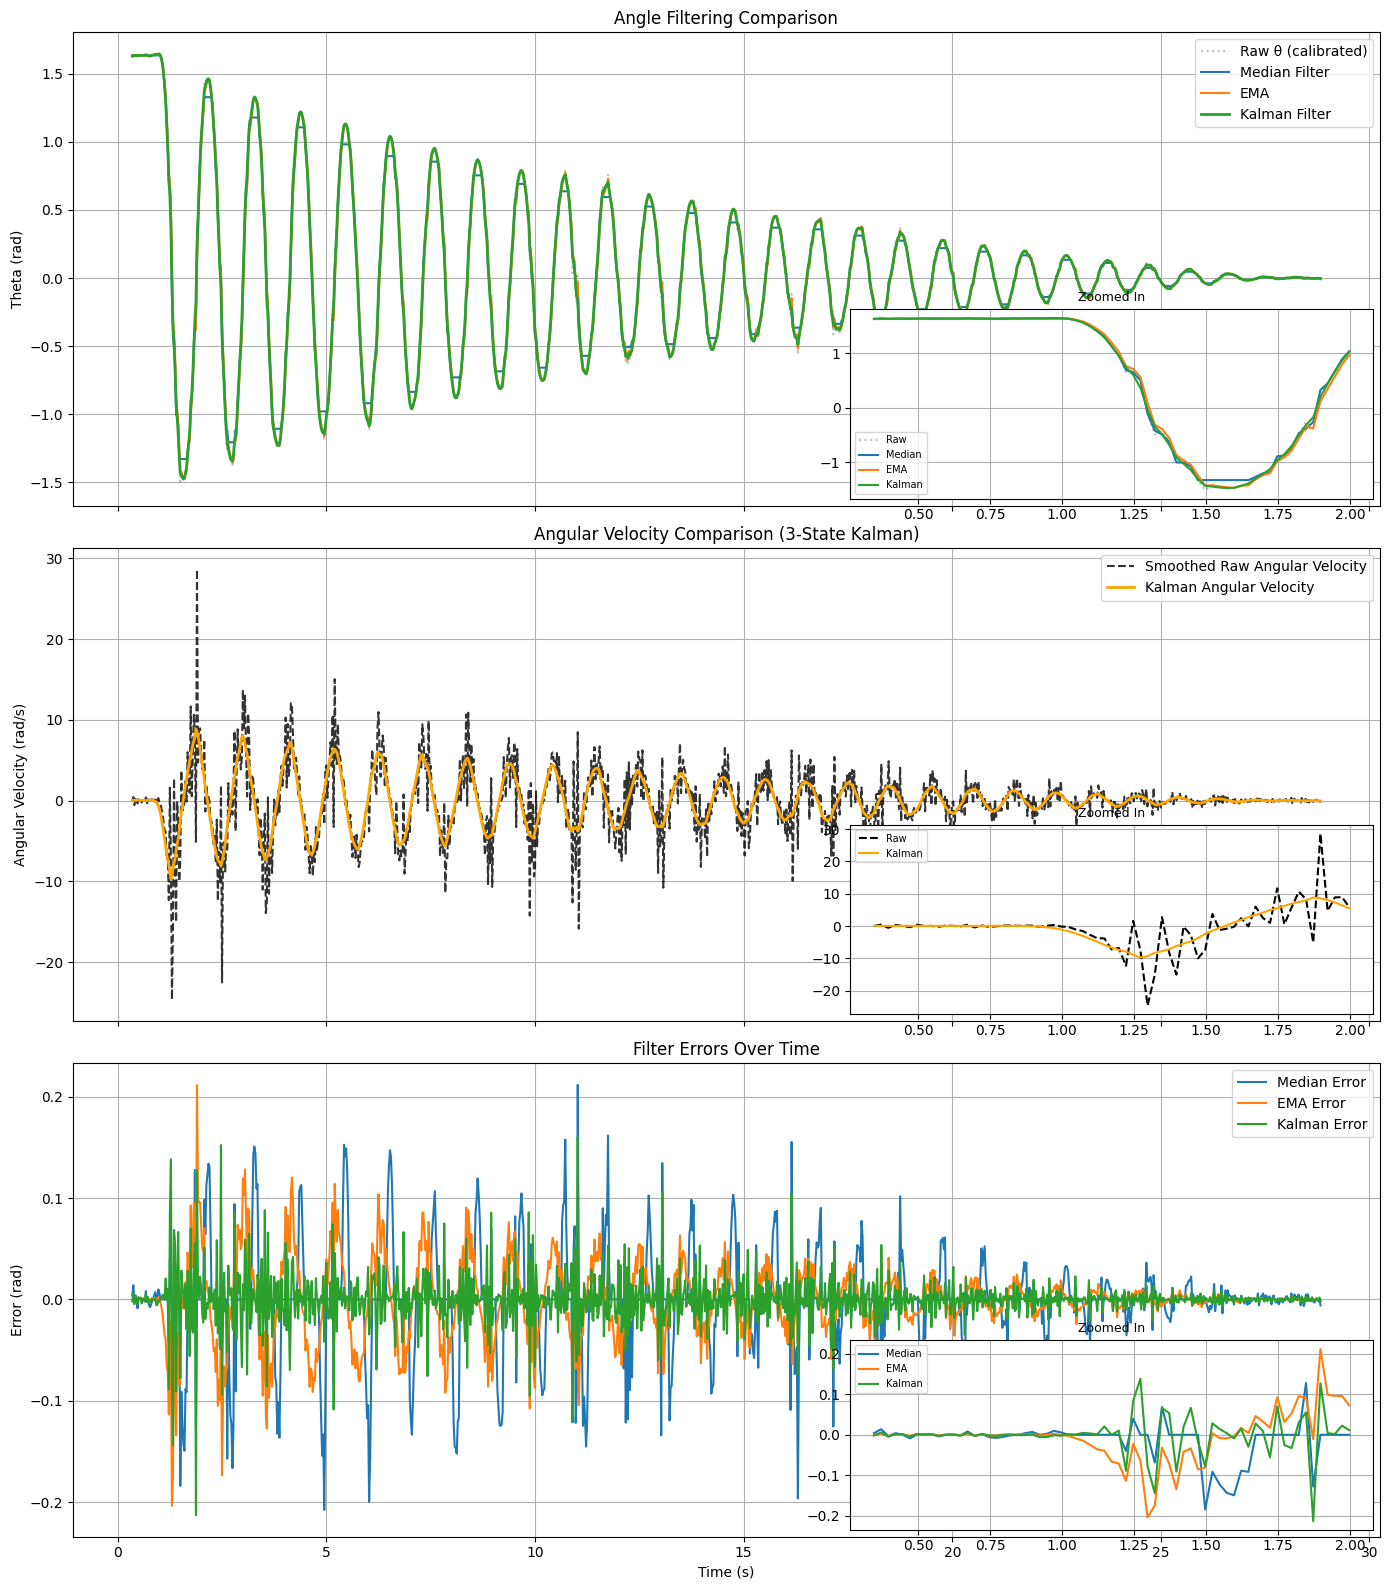

/var/folders/hk/35r4d3px72v99cr1lfr8nw000000gn/T/ipykernel_82720/2001521411.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


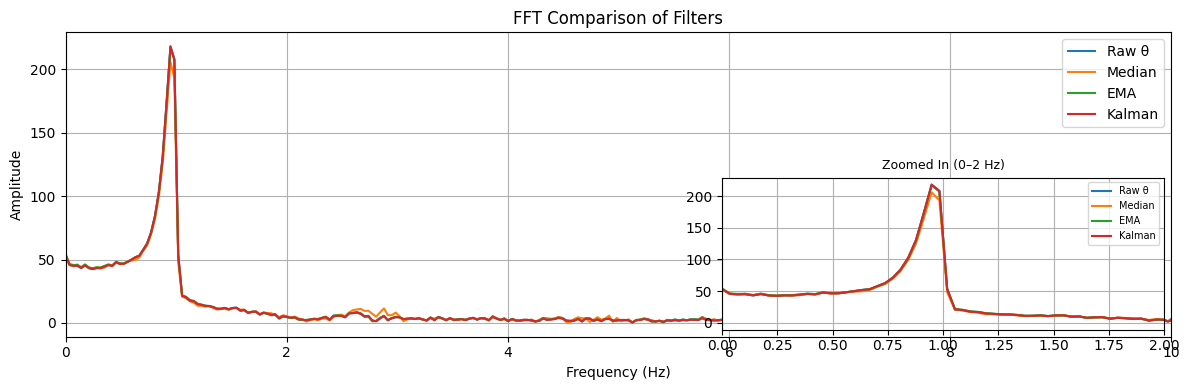

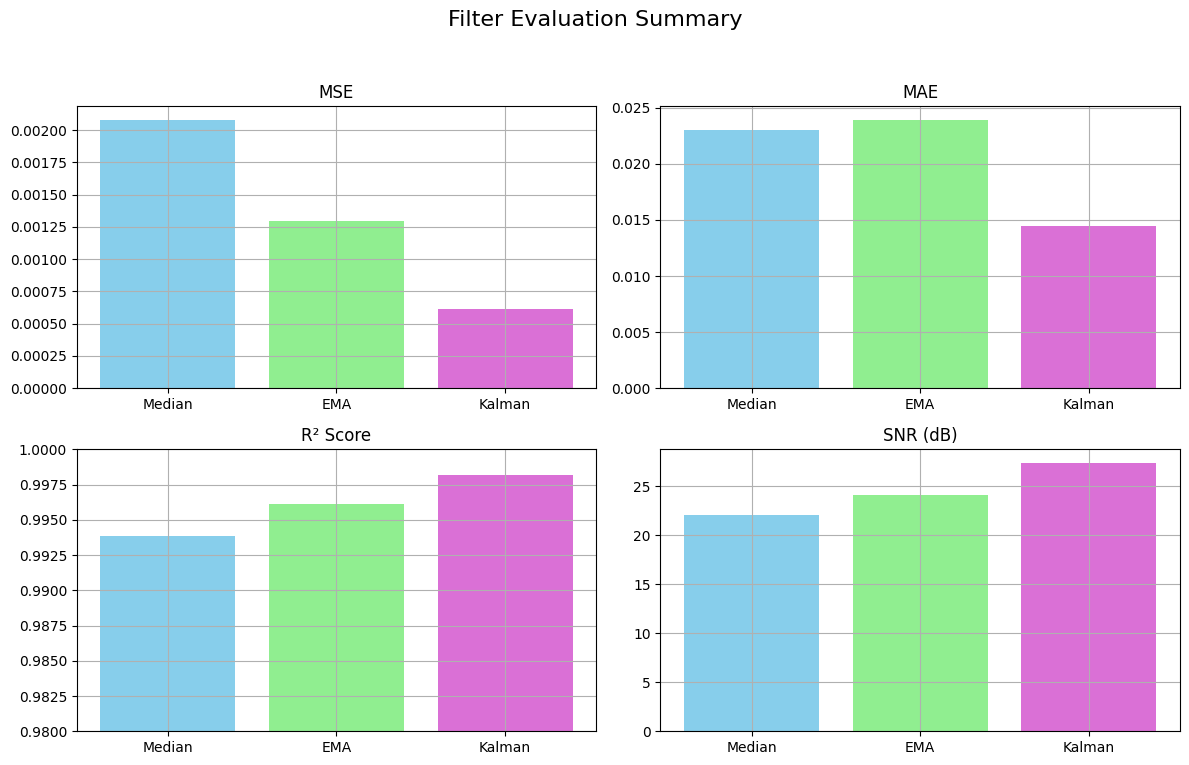

Filter Evaluation Metrics:

Median Filter:
  MSE : 0.002079
  MAE : 0.023042
  R²  : 0.993817
  SNR : 22.09 dB

EMA Filter:
  MSE : 0.001296
  MAE : 0.023935
  R²  : 0.996145
  SNR : 24.14 dB

Kalman Filter:
  MSE : 0.000615
  MAE : 0.014491
  R²  : 0.998172
  SNR : 27.38 dB
Kalman output saved to: kalman_output.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pykalman import KalmanFilter
from scipy.fft import fft, fftfreq
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# === Load and prepare data ===
filename = "half_theta_2"
folder = "single_pendulum_movements"
df = pd.read_csv(f"datasets/{folder}/{filename}.csv") 

df['time_sec'] = df['time'] / 1_000_000
df = df.sort_values(by='time_sec').reset_index(drop=True)
df['dt'] = df['time_sec'].diff().fillna(0)
dt_mean = df['dt'].mean()

tick_to_m = 0.001276
df['x_pivot_m'] = df['newPosition'] * tick_to_m * -1

# === Compute and calibrate theta ===
df['theta_raw'] = np.arctan2(df['xAccl'], df['zAccl'])
theta_at_rest = df.tail(50)['theta_raw'].mean()
df['theta_calib'] = df['theta_raw'] - theta_at_rest

# === Apply Filters ===
df['theta_med'] = medfilt(df['theta_calib'], kernel_size=15)
df['theta_ema'] = df['theta_calib'].ewm(alpha=0.7, adjust=False).mean()

# === 3-State Kalman Filter ===
A = [
    [1, dt_mean, 0.5 * dt_mean ** 2],
    [0, 1,       dt_mean],
    [0, 0,       1]
]
H = [[1, 0, 0]]

initial_state = [df['theta_calib'].iloc[0], 0, 0]
Q = np.diag([1e-4, 3e-2, 2e-1])
R = np.array([[0.0001]])

kf = KalmanFilter(
    transition_matrices=A,
    observation_matrices=H,
    initial_state_mean=initial_state,
    transition_covariance=Q,
    observation_covariance=R
)

filtered_state_means, _ = kf.smooth(df['theta_calib'].values)
df['theta_kalman'] = filtered_state_means[:, 0]
df['theta_dot_kalman'] = filtered_state_means[:, 1]
df['theta_ddot_kalman'] = filtered_state_means[:, 2]

# === Raw angular velocity ===
df['theta_dot_raw'] = df['theta_calib'].diff() / df['dt']
df['theta_dot_raw'] = df['theta_dot_raw'].fillna(0)
df['theta_dot_raw_smooth'] = gaussian_filter1d(df['theta_dot_raw'], sigma=2)

def plot_fft(signal, label, fs, ax):
    n = len(signal)
    freq = fftfreq(n, d=1/fs)[:n//2]
    spectrum = np.abs(fft(signal))[:n//2]
    ax.plot(freq, spectrum, label=label)


# === Plotting ===
fig, axs = plt.subplots(3, 1, figsize=(14, 16), sharex=True)
zoom_mask = df['time_sec'] < 2

# --- θ filtering comparison ---
axs[0].plot(df['time_sec'], df['theta_calib'], label='Raw θ (calibrated)', linestyle='dotted', color='gray', alpha=0.5)
axs[0].plot(df['time_sec'], df['theta_med'], label='Median Filter')
axs[0].plot(df['time_sec'], df['theta_ema'], label='EMA')
axs[0].plot(df['time_sec'], df['theta_kalman'], label='Kalman Filter', linewidth=2)
axs[0].set_ylabel("Theta (rad)")
axs[0].set_title("Angle Filtering Comparison")
axs[0].legend()
axs[0].grid(True)

# → Zoomed Inset
inset0 = inset_axes(axs[0], width="40%", height="40%", loc='lower right')
inset0.plot(df['time_sec'][zoom_mask], df['theta_calib'][zoom_mask], linestyle='dotted', color='gray', alpha=0.5, label='Raw')
inset0.plot(df['time_sec'][zoom_mask], df['theta_med'][zoom_mask], label='Median')
inset0.plot(df['time_sec'][zoom_mask], df['theta_ema'][zoom_mask], label='EMA')
inset0.plot(df['time_sec'][zoom_mask], df['theta_kalman'][zoom_mask], label='Kalman')
inset0.set_title("Zoomed In", fontsize=9)
inset0.legend(fontsize=7)
inset0.grid(True)

# --- θ̇ comparison ---
axs[1].plot(df['time_sec'], df['theta_dot_raw'], label='Smoothed Raw Angular Velocity', color='black', linestyle='--', alpha=0.8)
axs[1].plot(df['time_sec'], df['theta_dot_kalman'], label='Kalman Angular Velocity', color='orange', linewidth=2)
axs[1].set_ylabel("Angular Velocity (rad/s)")
axs[1].set_title("Angular Velocity Comparison (3-State Kalman)")
axs[1].legend()
axs[1].grid(True)

# → Zoomed Inset
inset1 = inset_axes(axs[1], width="40%", height="40%", loc='lower right')
inset1.plot(df['time_sec'][zoom_mask], df['theta_dot_raw'][zoom_mask], color='black', linestyle='--', label='Raw')
inset1.plot(df['time_sec'][zoom_mask], df['theta_dot_kalman'][zoom_mask], color='orange', label='Kalman')
inset1.set_title("Zoomed In", fontsize=9)
inset1.legend(fontsize=7)
inset1.grid(True)

# --- Filter error comparison ---
errors = {
    'Median': df['theta_calib'] - df['theta_med'],
    'EMA': df['theta_calib'] - df['theta_ema'],
    'Kalman': df['theta_calib'] - df['theta_kalman']
}
for method, err in errors.items():
    axs[2].plot(df['time_sec'], err, label=f'{method} Error')
axs[2].set_ylabel("Error (rad)")
axs[2].set_title("Filter Errors Over Time")
axs[2].set_xlabel("Time (s)")
axs[2].legend()
axs[2].grid(True)

# → Zoomed Inset
inset2 = inset_axes(axs[2], width="40%", height="40%", loc='lower right')
for method, err in errors.items():
    inset2.plot(df['time_sec'][zoom_mask], err[zoom_mask], label=method)
inset2.set_title("Zoomed In", fontsize=9)
inset2.legend(fontsize=7)
inset2.grid(True)

plt.tight_layout()
plt.show()

# === FFT Plot with Zoom ===
fs = 1 / df['dt'].mean()
fig, ax = plt.subplots(figsize=(12, 4))
plot_fft(df['theta_calib'], 'Raw θ', fs, ax)
plot_fft(df['theta_med'], 'Median', fs, ax)
plot_fft(df['theta_ema'], 'EMA', fs, ax)
plot_fft(df['theta_kalman'], 'Kalman', fs, ax)
ax.set_title("FFT Comparison of Filters")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude")
ax.set_xlim([0, 10])
ax.legend()
ax.grid(True)

# → Zoomed FFT inset for low frequencies
inset_fft = inset_axes(ax, width="40%", height="50%", loc='lower right')
plot_fft(df['theta_calib'], 'Raw θ', fs, inset_fft)
plot_fft(df['theta_med'], 'Median', fs, inset_fft)
plot_fft(df['theta_ema'], 'EMA', fs, inset_fft)
plot_fft(df['theta_kalman'], 'Kalman', fs, inset_fft)
inset_fft.set_xlim([0, 2])
inset_fft.set_title("Zoomed In (0–2 Hz)", fontsize=9)
inset_fft.legend(fontsize=7)
inset_fft.grid(True)

plt.tight_layout()
plt.show()

# === Evaluation Metrics ===
def snr(signal, noise):
    return 10 * np.log10(np.var(signal) / np.var(noise))

# === Evaluation Metrics Bar Plot ===
filters = ['Median', 'EMA', 'Kalman']
mse_vals = []
mae_vals = []
r2_vals = []
snr_vals = []

for name, pred in [('Median', df['theta_med']), ('EMA', df['theta_ema']), ('Kalman', df['theta_kalman'])]:
    mse_vals.append(mean_squared_error(df['theta_calib'], pred))
    mae_vals.append(mean_absolute_error(df['theta_calib'], pred))
    r2_vals.append(r2_score(df['theta_calib'], pred))
    snr_vals.append(snr(df['theta_calib'], df['theta_calib'] - pred))

# Plot all metrics in one figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

bar_width = 0.5
colors = ['skyblue', 'lightgreen', 'orchid']

axs[0].bar(filters, mse_vals, color=colors)
axs[0].set_title('MSE')
axs[0].grid(True)

axs[1].bar(filters, mae_vals, color=colors)
axs[1].set_title('MAE')
axs[1].grid(True)

axs[2].bar(filters, r2_vals, color=colors)
axs[2].set_ylim([0.98, 1])
axs[2].set_title('R² Score')
axs[2].grid(True)

axs[3].bar(filters, snr_vals, color=colors)
axs[3].set_title('SNR (dB)')
axs[3].grid(True)

plt.suptitle("Filter Evaluation Summary", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


print("Filter Evaluation Metrics:")
for name, pred in [('Median', df['theta_med']), ('EMA', df['theta_ema']), ('Kalman', df['theta_kalman'])]:
    mse = mean_squared_error(df['theta_calib'], pred)
    mae = mean_absolute_error(df['theta_calib'], pred)
    r2 = r2_score(df['theta_calib'], pred)
    snr_val = snr(df['theta_calib'], df['theta_calib'] - pred)
    print(f"\n{name} Filter:")
    print(f"  MSE : {mse:.6f}")
    print(f"  MAE : {mae:.6f}")
    print(f"  R²  : {r2:.6f}")
    print(f"  SNR : {snr_val:.2f} dB")

# === Save Kalman output ===
df_out = df[['time_sec', 'theta_kalman', 'theta_dot_kalman', 'theta_ddot_kalman', 'x_pivot_m']]
df_out.to_csv(f"datasets/filtered_datasets/{filename}_kalman_output.csv", index=False)
print("Kalman output saved to: kalman_output.csv")
